# 5章
## 主成分を抽出する

1. データを標準化
2. 共分散行列を作成
3. 共分散行列の固有値と固有ベクトルを取得
4. 固有値を降順でソートすることで、固有ベクトルをランク付け

In [1]:
import pandas as pd

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# トレーニングデータとテストデータに分割
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)


In [4]:
# 平均と標準偏差を用いて標準化
sc = StandardScaler()

In [5]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
import numpy as np

In [7]:
# 共分散行列を作成
conv_mat = np.cov(X_train_std.T)

# 固有値と固有ベクトルを計算
eigen_vals, eigen_vecs = np.linalg.eig(conv_mat)
print(eigen_vals)

[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


## 全分散と説明分散

In [8]:
# 固有値を合計
tot = sum(eigen_vals)
# 分散説明率を計算
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 分散説明率の累積和を取得
cum_var_exp = np.cumsum(var_exp)

In [9]:
import matplotlib.pyplot as plt

<BarContainer object of 13 artists>

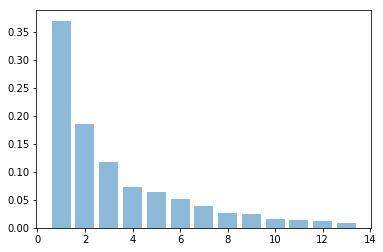

In [10]:
# 分散説明率の棒グラフを作成
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='indivisual explained variance')

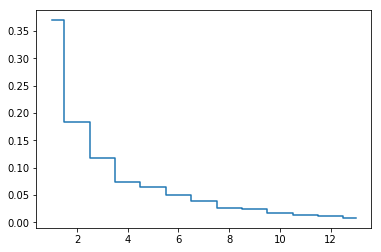

In [11]:
# 分散説明率の累積和の段階グラフを作成
plt.step(range(1, 14), var_exp, where='mid', label='comulative explained variance')

### 図からわかること
はじめの2つで分散の約60%を占めているということ

## 特徴変換  
固有値の大きいものから順に固有対を並び替え、選択された固有ベクトルから射影行列を共有する。

In [12]:
# (固有値、固有ベクトル) のタプルリストを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# 固有値、固有ベクトルのタプルを大きいものから準に選ぶ
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [13]:
# 最も大きい2つの固有値に対応する2つの固有ベクトルを集める
# 13 * 2 射影ベクトルが生成される
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print(w)

[[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [36]:
# 射影行列を使って、PCAの部分空間に変換(1 * 13)
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [37]:
X_train_pca = X_train_std.dot(w)(124 * 2)

TypeError: 'numpy.ndarray' object is not callable

In [38]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

In [ ]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## scikit-learnの主成分分析

In [20]:
from matplotlib.colors import ListedColormap

In [30]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    #　マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', 'Λ', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # 各種特徴を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果をもとのグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolor='block',
                    marker=markers[idx],
                    label=cl)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [32]:
# PCAのインスタンス生成
pca = PCA(n_components=2)

In [33]:
lr = LogisticRegression()

# トレーニングデータとテストデータでPCAを実行
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [34]:
lr.fit(X_train_pca, y_train)

c:\users\nsw00_907318\project\sano\sano\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\nsw00_907318\project\sano\sano\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


ValueError: Invalid RGBA argument: 'l'

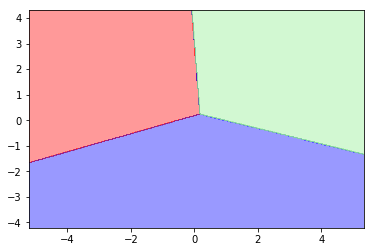

In [35]:
# 決定教会をプロット
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()